# Summary
In this notebook we try to use only the manually labels to fine-tune a BERT model.

The manual labeling scheme included `ignore` and `non-informative`. In this notebook I ignore it and run naively, changing thenm to `neutral`

In [ ]:
!nvidia-smi

Fri Nov 24 18:02:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers accelerate dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.


# Setup

In [ ]:
# Globals
# ---------------

# data locations
ORIGIN = './data/labeled_sample_and_splits/'
DATA_FILE = ORIGIN+'labeled_data_2023-11-07.csv'
train_idx_path = ORIGIN+'train_idx_2023-11-07.npy'
val_idx_path   = ORIGIN+'val_idx_2023-11-07.npy'
test_idx_path  = ORIGIN+'test_idx_2023-11-07.npy'
RELABELED_DATA_FILE = ORIGIN+'relabeled_data_2023-11-07.csv'
AUGMENTED_DATA_FILE = ORIGIN+'train_manually_labeled_augmented_2023-11-08.csv'

# training params
batch_size = 16
epochs = 3
seed_val = 1234

# Model
HF_BERT_MODEL = './models/roberta-base_pretrained_80000.pt'
HF_TOKENIZER = "./models/roberta-base_pretrained_tokenizer/"

# ---------------

import os
import sys


root = 'Your root folder'

os.chdir(root)
sys.path.append(root)

import re
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import time
import datetime
import random

import torch
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch import nn

from transformers import BertTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


Mounted at /content/drive


# Load Data

In [ ]:
data = pd.read_csv(DATA_FILE,index_col=0)
data['label'] = data['Negative']

train_idx = np.load(train_idx_path)
val_idx   = np.load(val_idx_path)
test_idx  = np.load(test_idx_path)

# relabeled_data = pd.read_csv(RELABELED_DATA_FILE,index_col=0)
augmented_data = pd.read_csv(AUGMENTED_DATA_FILE,index_col=0)
data.iloc[:5]

,title,comment,Negative,Natural,Positive,clean_label,label
0,Egypt cancels Israeli gas contract - Terminati...,Am I the only one who thinks Israel will now c...,0.0,0.0,1.0,related but neutral,0.0
1,Israeli soldiers break into an apartment at da...,Fucking animals! The Israelis are no better th...,1.0,0.0,0.0,anti israeli,1.0
2,An attack on Israel would be considered an att...,"Therefore, Fuck Israel = Fuck Canada, so.... f...",1.0,0.0,0.0,anti israeli,1.0
3,UN: 13-year-old Palestinian boy killed by Isra...,"Thanks for posting this article, Team of Israe...",1.0,0.0,0.0,anti israeli,1.0
4,Triple terror attack hits south of Israel\n,Where is the outrage? Because Israelis are dyi...,0.0,0.0,1.0,pro israeli,0.0


## Add Augmented data

In [ ]:
augmented_data = augmented_data[['title','augmented_comment', 'label']].rename({'augmented_comment': 'comment'}, axis = 1)

# Add new relabeled data to the labled data
data.drop(['clean_label'],axis=1,inplace=True)

a = data.shape
data = pd.concat([data,augmented_data], axis = 0, ignore_index = True)
b = data.shape
print(f'Adding relabeled data to data: {a}->{b}')

# update train_idx
original_N  = a[0]
new_N       = b[0]
missing_idx = np.arange(original_N,new_N)
a = len(train_idx)
original_train_idx = train_idx.copy()
train_idx = np.array(train_idx.tolist()+missing_idx.tolist())
b = len(train_idx)
print(f'Training examples: {a}->{b}')


Adding relabeled data to data: (3076, 6)->(5782, 6)
Training examples: 2706->5412


## Define Label for the Relabeled Data (skipped)

In [ ]:
relabeled_data = pd.read_csv(RELABELED_DATA_FILE,index_col=0)

# clean automatic labeling
relabeled_data['clean_label'][relabeled_data['clean_label'].str.contains('unrelated')] = 'unrelated'
relabeled_data['clean_label'][relabeled_data['clean_label'].str.contains('neutral')] = 'neutral'
relabeled_data['clean_label'][relabeled_data['clean_label'].isin(['anti semitic', 'anti israeli'])] = 'negative'
relabeled_data['clean_label'][relabeled_data['clean_label'].str.contains('pro israeli')] = 'positive'
relabeled_data['clean_label'] = (relabeled_data['clean_label'] == 'negative').astype(int)

display(pd.crosstab(relabeled_data['clean_label'],
            relabeled_data['label']))

# Keep only agreed observations
mask = (relabeled_data['label'] == relabeled_data['clean_label'])
a = relabeled_data.shape
relabeled_data = relabeled_data[mask].reset_index(drop=True)
b = relabeled_data.shape
print(f'Removing inconsistencies from relabeled data: {a}->{b}')

# Add new relabeled data to the labled data
relabeled_data.drop(['clean_label'],axis=1,inplace=True)

a = data.shape
data = pd.concat([data,relabeled_data], axis = 0, ignore_index = True)
b = data.shape
print(f'Adding relabeled data to data: {a}->{b}')

# update train_idx
original_N  = a[0]
new_N       = b[0]
missing_idx = np.arange(original_N,new_N)
a = len(train_idx)
original_train_idx = train_idx.copy()
train_idx = np.array(train_idx.tolist()+missing_idx.tolist())
b = len(train_idx)
print(f'Training examples: {a}->{b}')


<ipython-input-7-33c84f27dd54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relabeled_data['clean_label'][relabeled_data['clean_label'].str.contains('unrelated')] = 'unrelated'
<ipython-input-7-33c84f27dd54>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relabeled_data['clean_label'][relabeled_data['clean_label'].str.contains('neutral')] = 'neutral'
<ipython-input-7-33c84f27dd54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r

label,0.0,1.0
clean_label,,
0,1610,527
1,499,800


Removing inconsistencies from relabeled data: (3436, 7)->(2410, 7)
Adding relabeled data to data: (5782, 6)->(8192, 6)
Training examples: 5412->7822


## Shuffle Train Indices

In [ ]:
np.random.shuffle(train_idx)

In [ ]:
print('Train - Original')
display(data.iloc[original_train_idx].describe())
print('Train - New')
display(data.iloc[train_idx].describe())
print('Validation')
display(data.iloc[val_idx].describe())
print('Test')
display(data.iloc[test_idx].describe())


Train - Original


,Negative,Natural,Positive,label
count,2706.000000,2706.000000,2706.000000,5412.000000
mean,0.493348,0.293422,0.213230,0.493348
std,0.500048,0.455414,0.409664,0.500002
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Train - New


,Negative,Natural,Positive,label
count,5116.000000,5116.000000,5116.000000,7822.000000
mean,0.260946,0.155395,0.112979,0.443621
std,0.439193,0.362316,0.316598,0.496843
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Validation


,Negative,Natural,Positive,label
count,215.000000,215.000000,215.000000,215.000000
mean,0.483721,0.223256,0.293023,0.483721
std,0.500901,0.417400,0.456211,0.500901
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Test


,Negative,Natural,Positive,label
count,155.000000,155.000000,155.000000,155.000000
mean,0.464516,0.258065,0.277419,0.464516
std,0.500356,0.438988,0.449177,0.500356
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


## utils

In [ ]:
def report(y_true, y_pred,y_score):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
  roc_auc = np.round(metrics.auc(fpr, tpr),4)
  precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_score)
  pr_auc = np.round(metrics.auc(recall, precision),4)
  bacc = np.round(metrics.balanced_accuracy_score(y_true, y_pred),4)

  # plots
  plot_df = pd.DataFrame(
      {
          'Label':y_true,
          'Prediction':y_score,
          'Predicted Label':y_pred
          }
      )

  fig, axs = plt.subplots(1, 4, figsize = (12,3))
  sns.histplot(data = plot_df, x = 'Prediction', hue = 'Label', ax=axs[0])
  axs[0].set_title('Scores Distribution')

  axs[1].plot(fpr, tpr)
  axs[1].set_xlabel("False Positive Rate")
  axs[1].set_ylabel("True Positive Rate")
  axs[1].set_title('ROC')

  axs[2].plot(recall, precision)
  axs[2].set_xlabel("Recall")
  axs[2].set_ylabel("Precision")
  axs[2].set_title('PR Curve')

  crosstab = pd.crosstab(plot_df['Label'], plot_df['Predicted Label'], normalize='index')
  sns.heatmap(crosstab, annot=True, fmt='.2f', ax = axs[3])
  plt.tight_layout()
  plt.show()

  # prints
  print(f"Balanced Accuracy: {bacc}")
  print(f"AUC AUC:           {roc_auc}")
  print(f"PR AUC:            {pr_auc}")


In [ ]:

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


# Data Prep

In [ ]:
# sentences = np.array([f'{x} [SEP] {y}' for (x,y) in zip(data['title'].tolist(), zip(data['comment'].tolist()))])
sentences = np.array([f'{x} ; {y}' for (x,y) in zip(data['title'].tolist(), zip(data['comment'].tolist()))])
labels    = data[['label']].values


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(HF_TOKENIZER)
max_len = 512 # max of BERT, we have even longer sentences

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(sentences, desc='Processing sentences..'):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


Processing sentences..:   0%|          | 0/8192 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing sentences..: 100%|██████

In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
labels = labels.long()

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Egypt cancels Israeli gas contract - Termination of 20-year deal, which provided 40% of Israel's natural gas, seen as sign of fraying relations between allies
 ; ("Am I the only one who thinks Israel will now come up with an incredible source of energy to replace it? Israel's pretty damn good in a bind.",)
Token IDs: tensor([    0, 37552, 10061,    29,  3465,  1123,  1355,   111, 33890,  1258,
            9,   291,    12,   180,   432,     6,    61,  1286,   843,   207,
            9,  1870,    18,  1632,  1123,     6,   450,    25,  1203,     9,
         6664, 11918,  3115,   227,  4181, 50118, 25606,  6697, 10127,    38,
            5,   129,    65,    54,  4265,  1870,    40,   122,   283,    62,
           19,    41,  3997,  1300,     9,  1007,     7,  3190,    24,   116,
         1870,    18,  1256, 16490,   205,    11,    10, 23379, 45863,    43,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,    

In [ ]:
# Split, stratify
N = len(labels)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

dataset = TensorDataset(input_ids, attention_masks, labels)


In [ ]:
train_dataloader = DataLoader(
            dataset,                  # The training samples.
            sampler = train_sampler,  # Select batches randomly
            batch_size = batch_size   # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            dataset,                  # The validation samples.
            sampler = valid_sampler,  # Pull out batches sequentially.
            batch_size = batch_size   # Evaluate with this batch size.
        )


# Train


In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    HF_BERT_MODEL,          # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,               # The number of output labels--2 for binary classification.
                                  # You can increase this for multi-class tasks.
    output_attentions = False,    # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./models/roberta-base_pretrained_80000.pt and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,            # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8            # args.adam_epsilon  - default is 1e-8.
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    489.    Elapsed: 0:00:21.
  Batch    80  of    489.    Elapsed: 0:00:39.
  Batch   120  of    489.    Elapsed: 0:00:56.
  Batch   160  of    489.    Elapsed: 0:01:14.
  Batch   200  of    489.    Elapsed: 0:01:32.
  Batch   240  of    489.    Elapsed: 0:01:50.
  Batch   280  of    489.    Elapsed: 0:02:08.
  Batch   320  of    489.    Elapsed: 0:02:26.
  Batch   360  of    489.    Elapsed: 0:02:44.
  Batch   400  of    489.    Elapsed: 0:03:02.
  Batch   440  of    489.    Elapsed: 0:03:20.
  Batch   480  of    489.    Elapsed: 0:03:37.

  Average training loss: 0.56
  Training epcoh took: 0:03:41

Running Validation...


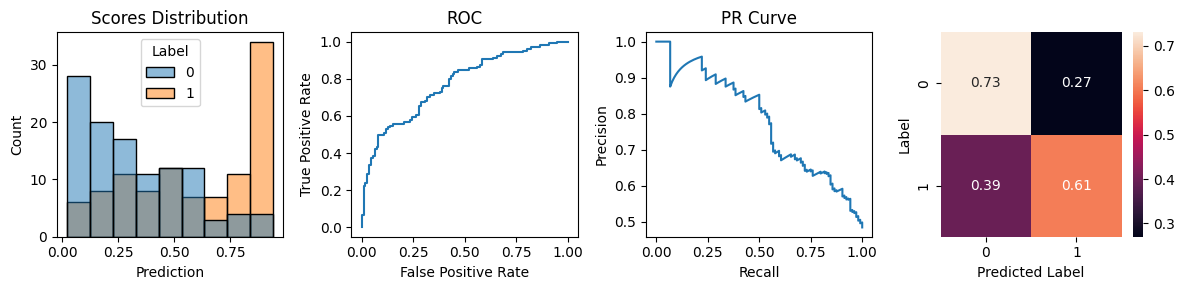

Balanced Accuracy: 0.6677
AUC AUC:           0.7709
PR AUC:            0.7771
  Validation Loss: 0.58
  Validation took: 0:00:03

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    489.    Elapsed: 0:00:18.
  Batch    80  of    489.    Elapsed: 0:00:36.
  Batch   120  of    489.    Elapsed: 0:00:54.
  Batch   160  of    489.    Elapsed: 0:01:12.
  Batch   200  of    489.    Elapsed: 0:01:29.
  Batch   240  of    489.    Elapsed: 0:01:47.
  Batch   280  of    489.    Elapsed: 0:02:05.
  Batch   320  of    489.    Elapsed: 0:02:23.
  Batch   360  of    489.    Elapsed: 0:02:41.
  Batch   400  of    489.    Elapsed: 0:02:59.
  Batch   440  of    489.    Elapsed: 0:03:17.
  Batch   480  of    489.    Elapsed: 0:03:35.

  Average training loss: 0.37
  Training epcoh took: 0:03:39

Running Validation...


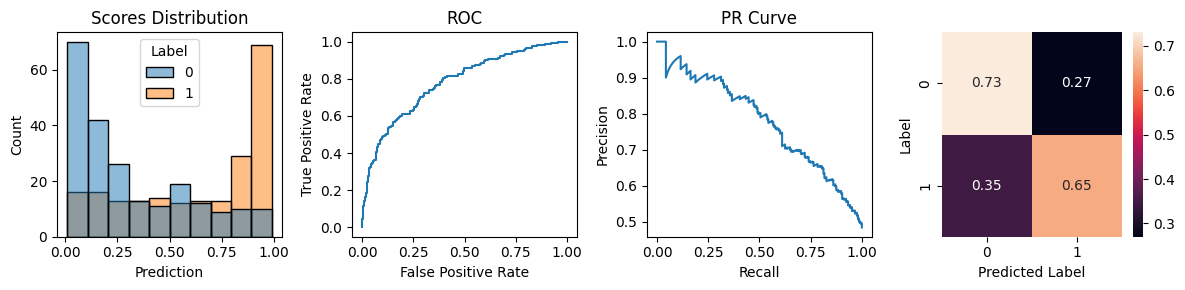

Balanced Accuracy: 0.6918
AUC AUC:           0.7785
PR AUC:            0.7781
  Validation Loss: 0.64
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    489.    Elapsed: 0:00:18.
  Batch    80  of    489.    Elapsed: 0:00:36.
  Batch   120  of    489.    Elapsed: 0:00:54.
  Batch   160  of    489.    Elapsed: 0:01:12.
  Batch   200  of    489.    Elapsed: 0:01:29.
  Batch   240  of    489.    Elapsed: 0:01:47.
  Batch   280  of    489.    Elapsed: 0:02:05.
  Batch   320  of    489.    Elapsed: 0:02:23.
  Batch   360  of    489.    Elapsed: 0:02:41.
  Batch   400  of    489.    Elapsed: 0:02:59.
  Batch   440  of    489.    Elapsed: 0:03:17.
  Batch   480  of    489.    Elapsed: 0:03:35.

  Average training loss: 0.22
  Training epcoh took: 0:03:39

Running Validation...


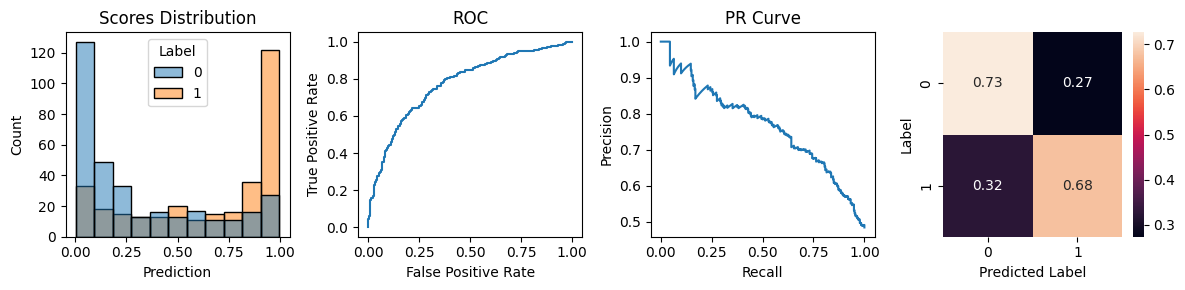

Balanced Accuracy: 0.7015
AUC AUC:           0.7742
PR AUC:            0.7654
  Validation Loss: 0.90
  Validation took: 0:00:03

Training complete!
Total training took 0:11:07 (h:mm:ss)


In [ ]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


# store values
labels_total = []
probs_total  = []


# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        scheduler.step()

        # store
        probs = torch.softmax(logits, dim=1)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # calc KPIs
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # sys.exit(0)

        with torch.no_grad():

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        probs = torch.softmax(logits, dim=1).detach().cpu().numpy().tolist()
        b_labels = b_labels.detach().cpu().numpy().tolist()
        labels_total += b_labels
        probs_total  += probs

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

    y_true  = np.squeeze(np.array(labels_total))
    y_pred  = np.array(probs_total).argmax(axis=1)
    y_score = np.array(probs_total)[:,1]

    report(y_true, y_pred,y_score)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
# Save model and tokenizer
model.save_pretrained("./models/roberta_augmentation_label_spreading_after_pretraining_241123_model.pt")
tokenizer.save_pretrained("./models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer")


('./models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer/tokenizer_config.json',
 './models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer/special_tokens_map.json',
 './models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer/vocab.json',
 './models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer/merges.txt',
 './models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer/added_tokens.json')

# END

In [ ]:
sys.exit(0)